In [ ]:
%cd /content

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

/content
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1754, done.
remote: Counting objects: 100% (439/439), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 1754 (delta 357), reused 352 (delta 329), pack-reused 1315
Receiving objects: 100% (1754/1754), 124.80 MiB | 12.98 MiB/s, done.
Resolving deltas: 100% (830/830), done.
/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 21.7 MB/s eta 0:00:00
  Installing build depende

In [ ]:
%cd /content/Grounded-Segment-Anything

/content/Grounded-Segment-Anything


In [ ]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont


# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline
from torchvision.ops import box_convert

from huggingface_hub import hf_hub_download

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#load the model grounding dino
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    import os
    print(os.getcwd())
    return model

In [ ]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
/content/Grounded-Segment-Anything


In [ ]:
!rm -rf /content/Grounded-Segment-Anything/images

In [ ]:
# Load image
from PIL import Image

# Open the image file
def load_images(path,ext):
    image = Image.open(path)

    subfolders = ["pngImages", "jpgImages"]
    main_folder = "/content/Grounded-Segment-Anything/images/"

    os.makedirs(main_folder)
    os.makedirs(main_folder+subfolders[0])
    os.makedirs(main_folder+subfolders[1])
    resized_image = image.resize((1024, 1024))
    # based on image extension opening the image
    if ext == 'jpg' :
      resized_image.save("/content/Grounded-Segment-Anything/images/jpgImages/resized_image.jpg")  # Save the resized image to a file
      local_image_path = "/content/Grounded-Segment-Anything/images/jpgImages/resized_image.jpg"
    else:
      resized_image.save("/content/Grounded-Segment-Anything/images/pngImages/resized_image.png")  # Save the resized image to a file
      local_image_path = "/content/Grounded-Segment-Anything/images/pngImages/resized_image.png"


    # Save the resized image
    # resized_image.save("resized_image.jpg")  # Save the resized image to a file

    # local_image_path = "/content/Grounded-Segment-Anything/resized_image.jpg"


    image_source, image = load_image(local_image_path)
    return image_source, image
# Image.fromarray(image_source)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_source, image = load_images('/content/drive/MyDrive/rust/Gemini_Generated_Image_u1vex1u1vex1u1ve.jpg','jpg')
#/content/drive/MyDrive/rust/Heavy rust 5.png
Image.fromarray(image_source)

In [ ]:
from typing import Tuple, List
# fn to annotate the bounding boxes on the image
def annotate1(image_source: np.ndarray, boxes: torch.Tensor, logits: torch.Tensor, phrases: List[str]) -> np.ndarray:
    h, w, _ = image_source.shape

    boxes = boxes * torch.Tensor([w, h, w, h])

    xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

    detections = sv.Detections(xyxy=xyxy)

    labels = [
        f"{phrase} {logit:.2f}"
        for phrase, logit
        in zip(phrases, logits)
    ]

    box_annotator = sv.BoxAnnotator()
    annotated_frame = cv2.cvtColor(image_source, cv2.COLOR_RGB2BGR)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
    return annotated_frame, xyxy

In [ ]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):

  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )


  print(phrases)
  annotated_frame,xyxy = annotate1(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes, logits,xyxy

['rust reddish - brown coating', 'rust reddish - brown coating']


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


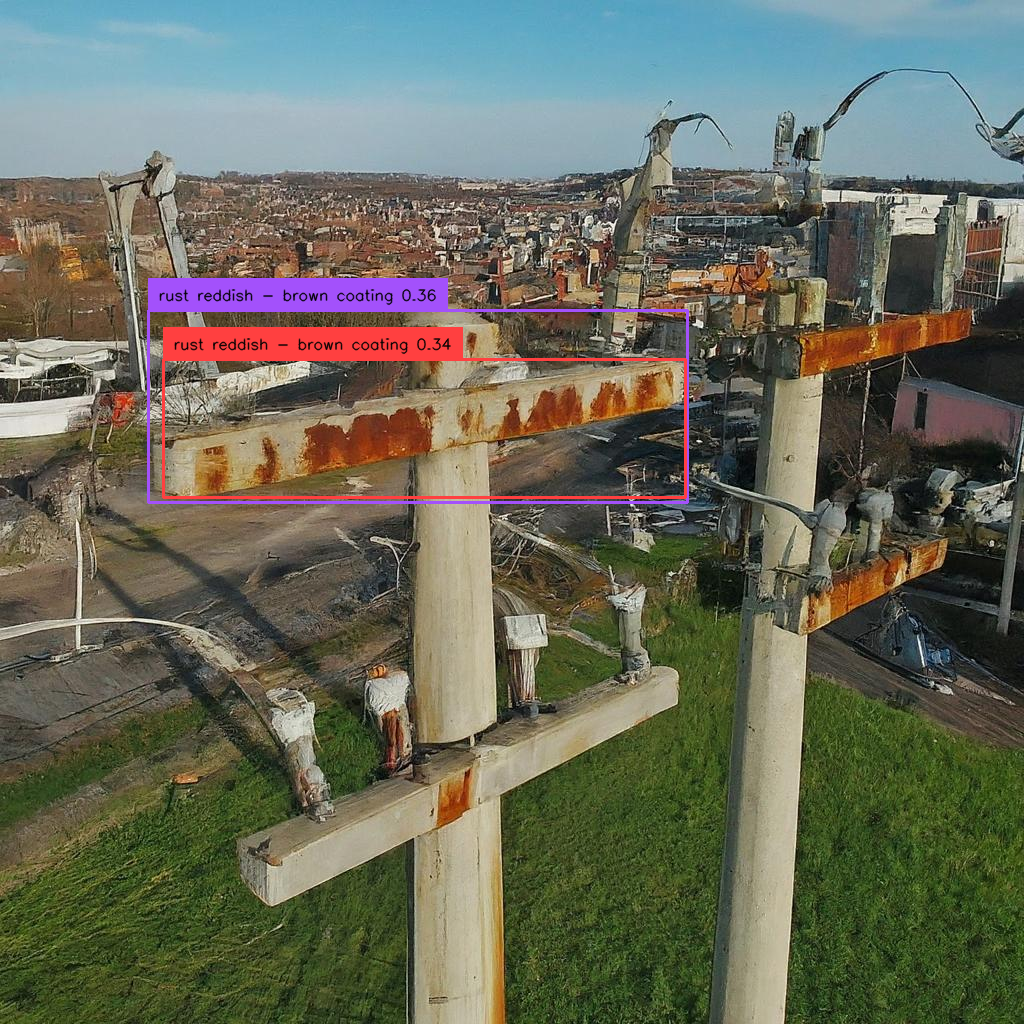

In [ ]:
#calling the detect function to do the detection part with text based prompt
annotated_frame, detected_boxes, detected_logits,xyxy= detect(image, text_prompt="rust, reddish-brown color", model=groundingdino_model)
Image.fromarray(annotated_frame)

In [ ]:
#saving the cropped image of bounding box area based on the extension
def save_crop_image(xyxy, ext):
  i = 0
  folder_path = '/content/cropped_images'
  if ext == 'jpg':
    local_image_path = "/content/Grounded-Segment-Anything/images/jpgImages/resized_image.jpg"
    original_image = Image.open(local_image_path)
    for row in xyxy:
        print(f"row is running", i )

        # Convert the row to a tuple and append to the list
        array_tuple = (tuple(row))
        cropped_image = original_image.crop(array_tuple)
        cropped_image.save(os.path.join(folder_path, f"cropped_image{i}.jpg"))
        i+=1


  else:
    local_image_path = "/content/Grounded-Segment-Anything/images/pngImages/resized_image.png"
    original_image = Image.open(local_image_path)
    for row in xyxy:
        # Convert the row to a tuple and append to the list
        array_tuple = (tuple(row))
        cropped_image = original_image.crop(array_tuple)

        cropped_image.save(os.path.join(folder_path, f"cropped_image{i}.png"))
        i+=1
  shutil.rmtree('/content/Grounded-Segment-Anything/images')
  # shutil.rmtree('/content/Grounded-Segment-Anything/images/j')







In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding


In [ ]:
! pip install openai==1.0.0
! pip install instructor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.23.2
    Uninstalling openai-1.23.2:
      Successfully uninstalled openai-1.23.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.8 MB/s eta 0:00:00
  Using cached openai-1.23.2-py3-none-any.whl (311 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.0.0
    Uninstalling openai-1.0.0:
      Successfully uninstalled openai-1.0.0


In [ ]:
import os
from PIL import Image
# resizing the cropped images
def resize_crop_image():
# Path to the folder containing the images
  folder_path = "/content/cropped_images"
  resized_path = "/content/resized_images"
  # Get a list of all files in the folder
  file_list = os.listdir(folder_path)

  # Iterate through each file in the folder
  for file_name in file_list:
      # Check if the file is an image (you may want to add more file extensions if needed)
      if file_name.endswith(".jpg") or file_name.endswith(".png"):
          # Open the image file
          image_path = os.path.join(folder_path, file_name)
          image = Image.open(image_path)
          print(image.size)
          # Resize the image to 1024x1024
          resized_image = image.resize((1024, 1024))

          # Save the resized image back to the same folder
          resized_image.save(os.path.join(resized_path, f"resized_{file_name}"))




In [ ]:
import instructor
from instructor import Mode
from openai import OpenAI
from pydantic import BaseModel, Field
from pprint import pprint
import base64
# from dotenv import load_dotenv

# load_dotenv()

client = instructor.patch(OpenAI(), mode=Mode.MD_JSON)
# reading the image and encoding it into encode it into base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

class ObjectDetection(BaseModel):
    """
    You are an object detection expert.
    From the given list ,['High Rust', 'Low Rust', 'Medium Rust'] .
    First identify if the object exist in the image. If object exist then provide the bounding box of the object and object name.
    """
    x: int  = Field(description="x coordinate of detected object", default=0)
    y: int = Field(description="y coordinate of detected object", default=0)
    object_found_details: str = Field(description="Details of detected object.", default="")
    image_description: str = Field(descripion="Description of image.", default="")

#fn for calling gpt 4 for an image
def ask_gpt4_vision(system_instrutions, question, image_path):
    base64_image = encode_image(image_path)

    detected = client.chat.completions.create(
        response_model=ObjectDetection,
        model="gpt-4-turbo",
        max_tokens=200,
        messages=[
            {
                "role": "system",
                "content": system_instrutions
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": question},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        },
                    },
                ],
            }
        ],
    )

    return {"x": detected.x, "y": detected.y, "object_found_details": detected.object_found_details}

# image_path = "assets/kitten-and-puppy.webp"
# image_path = "assets/puppy.jpg"
# image_path = ""




#coordinates = ask_gpt4_vision(system_instructions, question, image_path)
# to call the gpt 4 on the cropped images
#for call ing gpt4 on number of images present in the folder
def gpt4_vision_call(resized_path, system_instructions, questions):
  file_list = os.listdir(resized_path)
  detected_labels = []
  # print(file_list)
  for files in file_list:
        print(files)
        if files.endswith(".jpg") or files.endswith(".png"):
          # Open the image file
          image_path = os.path.join(resized_path, files)
          print(image_path)
          coordinates = ask_gpt4_vision(system_instructions, question, image_path)

          detected_labels.append(coordinates['object_found_details'])
  print(detected_labels)
  return detected_labels





In [ ]:
system_instructions =   """

As an expert in object detection, you specialize in pinpointing specific elements within images.
Given your expertise, you can efficiently analyze the provided image for any items listed, such as ['High Rust', 'Low Rust', 'Medium Rust'].
Once identified, you will accurately mark their presence by providing both the bounding box coordinates and the name of the detected object.
It's important to process the image while preserving its dimensions at 1024x1024 pixels.
"""
question = "Can you tell me type of rust on the image. The image is of size 1024x1024"

detected_labels = gpt4_vision_call('/content/resized_images', system_instructions, question)

resized_cropped_image0.png
/content/resized_images/resized_cropped_image0.png
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg
.ipynb_checkpoints
['High Rust', 'High Rust']


In [ ]:
!openai --version

openai 1.23.2


In [ ]:
# save the predicted images labels are from gpt 4 and bounding box and image from grounding dino using annotate 1 fn
def save_pred_image(detected_labels, image_soruce, i):
  annotated_frame_1,xyxy = annotate1(image_source=image_source, boxes=detected_boxes, logits=detected_logits, phrases=detected_labels)
  annotated_frame = annotated_frame_1[...,::-1]
  rgb_image = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
  cv2.imwrite(f"/content/predicted_images/annotated_image_test{i}.jpg", rgb_image)

In [ ]:
import os

import shutil
# code to run and predict the image category
# # Path to your folder in Google Drive
folder_path1 = '/content/rust'

# Get the list of all files in the folder
files = os.listdir(folder_path1)
ext = ""
# Print the list of files
i = 0
for file_name in files:
  folder_path = "/content/"
  folders = ["cropped_images", "resized_images", "predicted_images"]
  if not os.path.exists(folder_path+folders[0]):
    os.makedirs(folder_path+folders[0])
  #   print("Directory 'images' created successfully.")
  # else:
  #     print("Directory 'images' already exists.")

  if not os.path.exists(folder_path+folders[1]):
    os.makedirs(folder_path+folders[1])
  #   print("Directory 'images' created successfully.")
  # else:
  #     print("Directory 'images' already exists.")

  if not os.path.exists(folder_path+folders[2]):
    os.makedirs(folder_path+folders[2])
    print("Directory 'images' created successfully. predicted_images")
  else:
      print("Directory 'images' already exists. predicted_images")

  print(file_name)
  if  file_name.endswith('jpg') :
    ext = 'jpg'
  else:
    ext = 'png'
  print(ext)

  # path='/content/drive/MyDrive/rust/2.jpg'
  file_path = os.path.join(folder_path1, file_name)
  image_source, image =load_images(file_path, ext)
  # print(type(image_source),type(image))
  annotated_frame, detected_boxes, detected_logits,xyxy= detect(image, text_prompt="rust", model=groundingdino_model)

  save_crop_image(xyxy, ext)
  resize_crop_image()
  print(i)
  i +=1
  detected_labels = gpt4_vision_call('/content/resized_images', system_instructions, question)

  save_pred_image(detected_labels, image_source,i)
  shutil.rmtree(folder_path+folders[0])
  shutil.rmtree(folder_path+folders[1])
  os.remove(file_path)
# # shutil.rmtree(folder_path+folders[2])








Directory 'images' created successfully. predicted_images
Low rust 3.jpg
jpg


['rust']
row is running 0
(768, 824)
0
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_oyk56xoyk56xoyk5.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(269, 963)
1
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
4.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(241, 807)
(521, 813)
2
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['High Rust', 'High Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_cwkn1tcwkn1tcwkn.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(346, 1020)
3
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
No rust 7.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(98, 529)
4
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['No rust detected on the wooden utility pole.']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_35x4pp35x4pp35x4.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(1001, 895)
5
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['Medium Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_cwkn1qcwkn1qcwkn.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(255, 1020)
(1022, 1019)
6
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['High Rust', 'High Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_c37m4dc37m4dc37m (1).jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


[]
7
[]
Directory 'images' already exists. predicted_images
9.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(133, 857)
(192, 500)
8
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['Medium Rust', 'High Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_oyk56voyk56voyk5.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(329, 806)
9
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['Medium Rust']
Directory 'images' already exists. predicted_images
Medium rust 4.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(549, 551)
10
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_ywz06xywz06xywz0.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(150, 241)
(109, 192)
11
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['High Rust on the roof and top panel, Medium Rust on the side panels', 'High Rust located primarily on the upper and right side of the structure.']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_d16y9qd16y9qd16y.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(1021, 1021)
(202, 1017)
12
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['Medium Rust', 'Medium Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_h2q2vfh2q2vfh2q2.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(228, 984)
13
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_jurrbcjurrbcjurr.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(571, 1020)
14
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
104131892.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(194, 961)
15
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['Medium Rust']
Directory 'images' already exists. predicted_images
Medium rust 3.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust', 'rust', 'rust', 'rust']
row is running 0
row is running 1
row is running 2
row is running 3
row is running 4
(125, 82)
(76, 74)
(170, 174)
(503, 395)
(108, 68)
16
resized_cropped_image3.jpg
/content/resized_images/resized_cropped_image3.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image4.jpg
/content/resized_images/resized_cropped_image4.jpg
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg
resized_cropped_image2.jpg
/content/resized_images/resized_cropped_image2.jpg
resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['High Rust', 'High Rust', 'High Rust', 'High Rust', '']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_ywz06uywz06uywz0.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(1020, 936)
17
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_oyk56soyk56soyk5.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(328, 806)
18
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['Medium Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_fdmldnfdmldnfdml.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(84, 877)
(163, 880)
19
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['High Rust', 'High Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_h2q2vgh2q2vgh2q2.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(1019, 958)
20
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_7x4h7c7x4h7c7x4h.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(567, 1020)
21
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
Heavy rust 4.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(653, 582)
22
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_quva73quva73quva.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(1020, 940)
(433, 460)
23
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['Low Rust', '']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_wrdcx8wrdcx8wrdc.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(484, 1021)
24
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_9nhmhl9nhmhl9nhm.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(270, 1020)
25
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
10.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(435, 196)
26
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['Low Rust detected on the metal roof.']
Directory 'images' already exists. predicted_images
Medium rust 1.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(590, 959)
27
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_h2q2veh2q2veh2q2.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(93, 75)
(830, 1018)
28
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['', 'Low Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_c37m4dc37m4dc37m.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(1020, 943)
29
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_u1vex1u1vex1u1ve.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(531, 187)
(514, 136)
30
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['High Rust', 'High Rust']
Directory 'images' already exists. predicted_images
No rust 1.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


[]
31
[]
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_quva76quva76quva.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(82, 91)
(1020, 1019)
32
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['High Rust', 'Low Rust']
Directory 'images' already exists. predicted_images
12.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(383, 961)
(487, 962)
33
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['High Rust', 'Medium Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_cgrm0acgrm0acgrm.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(1019, 1021)
34
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_qqcritqqcritqqcr.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(705, 1021)
35
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['Medium Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_oyk56uoyk56uoyk5.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(510, 958)
36
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust detected on the upper metal structures around the bolts']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_fdmldofdmldofdml.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(173, 1018)
37
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
Heavt Rust 1.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust', 'rust']
row is running 0
row is running 1
row is running 2
(628, 937)
(547, 937)
(325, 387)
38
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image2.jpg
/content/resized_images/resized_cropped_image2.jpg
resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['High Rust', 'High Rust', 'High Rust']
Directory 'images' already exists. predicted_images
8.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(380, 819)
(457, 569)
39
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['High Rust', 'Medium Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_r4t0nsr4t0nsr4t0.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust', 'rust']
row is running 0
row is running 1
row is running 2
(89, 1022)
(118, 1022)
(837, 1022)
40
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image2.jpg
/content/resized_images/resized_cropped_image2.jpg
resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['Medium Rust', 'High Rust', 'Medium Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_l3hlk3l3hlk3l3hl.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(141, 934)
41
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['The image contains High Rust, observed by the pronounced pitting and loss of metallic integrity']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_oyk56zoyk56zoyk5.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


[]
42
[]
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_f1svlqf1svlqf1sv.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(61, 836)
43
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['High Rust']
Directory 'images' already exists. predicted_images
Gemini_Generated_Image_l3hlk9l3hlk9l3hl.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust', 'rust']
row is running 0
row is running 1
(869, 1020)
(835, 89)
44
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


resized_cropped_image1.jpg
/content/resized_images/resized_cropped_image1.jpg
['Medium Rust', 'Medium Rust']
Directory 'images' already exists. predicted_images
No rust 6.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(211, 731)
45
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['Low Rust']
Directory 'images' already exists. predicted_images
No rust 5.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


[]
46
[]
Directory 'images' already exists. predicted_images
Medium rust 6.jpg
jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


['rust']
row is running 0
(499, 214)
47
resized_cropped_image0.jpg
/content/resized_images/resized_cropped_image0.jpg


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


BadRequestError: Error code: 400 - {'error': {'message': 'Your input image may contain content that is not allowed by our safety system.', 'type': 'invalid_request_error', 'param': None, 'code': 'content_policy_violation'}}